# Introduction

Before we get started, it's important to know in a basic level some aspects of Apache Spark. 

The world is facing a real challenge when it comes to data processing. Single machines do not have enough power and resources to perform computations on huge amounts of information (or the user may not have time to wait for the computation to finish).

A cluster, or group of machines, pools the resources of many machines together allowing us to use all the cumulative resources as if they were one. Now a group of machines alone is not powerful, you need a framework to coordinate work across them. 

Spark is a tool for just that, managing and coordinating the execution of tasks on data across a cluster of computers.


The purpose of this notebook is to present some features and capabilities that Spark may provide in terms of combining Python and SQL for those who are accustomed to working with both languages. 

#### Lazy Evaluation
All transformations in Spark are lazy, in that they do not compute their results right away. 

Instead, they just remember the transformations applied to some base dataset. The transformations are only computed when an action requires a result to be returned to the driver program. 

This design enables Spark to run more efficiently. 

For example, we can realize that a dataset created through map will be used in a reduce and return only the result of the reduce to the driver, rather than the larger mapped dataset.

This Wikipedia article about Lazy evaluation in computer programming theory may help with the concept:

https://en.wikipedia.org/wiki/Lazy_evaluation

Let's check with a quick practical example what this means in Python language

In [1]:
x = [1, 2, 3, 4, 5]

If you want to get the square number of each element in x we can use the lambda function.

In [2]:
x_squared = map(lambda k: k**2, x)
print(x_squared)

As you can see, x_squared is a map object and not a list = [1, 4, 9, 16, 25]  as you may expect.

This means that it has not been computed right away.

Although x_squared is a map object, we can still apply operations without computing them.

Let's get just the even numbers.

In [3]:
x_squared_filtered = filter(lambda k: k % 2 == 0, x_squared)
print(x_squared_filtered)

Now we have got a filter object.

Let's use the function reduce to finally compute and reduce our filtered values to a single value.

In [4]:
from functools import reduce

x_reduced = reduce(lambda k, p: k + p, x_squared_filtered)

In [5]:
print('After squaring each item of x, filtering even values, and reducing the list to a single value we get:\n')
print(' + '.join((str(i) + '\u00b2' for i in x if i % 2 == 0)), end=f' = {x_reduced}')

After squaring each item of x, filtering even values, and reducing the list to a single value we get:

2² + 4² = 20

With that being said, let's get started with Spark.

# Create SparkSession

The entry point into all functionality in Spark is the SparkSession class. 
A SparkSession can be used to create DataFrames, register DataFrames as tables, execute SQL over tables, cache tables, and read parquet files.

To create a basic SparkSession, just use SparkSession.builder.

It tells Spark how to access a cluster, however, for local testing and unit tests, you can pass “local” to run Spark in-process which is our case in this example.

source: https://spark.apache.org/docs/latest/sql-getting-started.html
'The Data Scientist's Guide to Apache Spark'

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName('Perth Housing') \
                    .getOrCreate()

# Property used to format output tables better
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 

spark

For more information about SparkSession parameters, modules, and functions: visit:

https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html?highlight=sparksession#pyspark.sql.SparkSession

# Spark SQL

Spark SQL is a Spark module for structured data processing.

The interfaces provided by Spark SQL provide Spark with more information about the structure of both the data and the computation being performed.

One use of Spark SQL is to execute SQL queries. 

Spark SQL can also be used to read data from an existing Hive installation. 

When running SQL from within another programming language the results will be returned as a Dataset/DataFrame.

Source:
https://spark.apache.org/docs/latest/sql-programming-guide.html

### Create Temporary View from PySpark DataFrame




Temporary views in Spark SQL are session-scoped and will disappear if the session that creates it terminates. 

If you want to have a temporary view that is shared among all sessions and keep alive until the Spark application terminates, you can create a global temporary view with the 'createGlobalTempView()' function. 

In this example, we are using createOrReplaceTempView() instead. 


Notice that the sql() function on a SparkSession enables applications to run SQL queries programmatically and returns the result as a DataFrame.

In [7]:
df = spark.read.csv('perth_data.csv', header=True, sep=',', inferSchema=False)

df.createOrReplaceTempView('temp_view')

spark.sql('SELECT * FROM temp_view').limit(3)

ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18300,Cockburn Central ...,1800,09-2018,6164,-32.1159,115.84245,LAKELAND SENIOR H...,0.8283385518162790,null
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26900,Kwinana Station,4900,02-2019,6167,-32.19347028,115.8595535,ATWELL COLLEGE,5.524324354371820,129
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22600,Challis Station,1900,06-2015,6111,-32.12057813,115.993579,KELMSCOTT SENIOR ...,1.649178183366990,113
1 Albert Street,Bellevue,255000,2,1,2,651,59,1953,17900,Midland Station,3600,07-2018,6056,-31.90054675,116.0380088,SWAN VIEW SENIOR ...,1.5714009366124700,null
1 Aman Place,Lockridge,325000,4,1,2,466,131,1998,11200,Bassendean Station,2000,11-2016,6054,-31.88579,115.94778,KIARA COLLEGE,1.5149216294528000,null


From the printed DataFrame, we can check each column and choose how we want them to be cleaned or transformed. 

Mostly, this process requires a deeper dive into the data depending on the quality of your data. You might need to define your own tranform funcitons. 

Pyspark also allows users to define their User Defined Functions (UDF's).

If you are interested in learning more, you can find more information in the Databicks Documentation:

https://docs.databricks.com/spark/latest/spark-sql/udf-python.html

### Create UDF (User Defined Function)

The first step to define an UDF in Python is to define a Python function. This process can be done if def or lambda functions.

In our example here, I am creating a Python class instead of a single function. 

This would allow us to add as many methods as we want in case we need more UDF's during the project.

In [8]:
class Converter():

    def __init__(self):
        pass

    def convert_str_title(self, value):
        if value is None or str(value).strip() == '':
            return None
        return str(value).strip().title()

    def create_udf(self, spark):
        from pyspark.sql.functions import udf
        from pyspark.sql.types import StringType
        # Here is where we define how we call it. Let's call it 'converter_str_title'
        spark.udf.register("convert_str_title", self.convert_str_title, StringType()) 

### Testing our UDF


Now, we can use our simple UDF as a SQL Function in our queries. In this example, we want to remove the unnecessary blank spaces and we also want just the first character in every word to be upper case.



In [9]:
# Don't forget to call the method 'create_udf' from the Conveter() class

Converter().create_udf(spark)

In [10]:
# Now we can call the converter_str_title() Function in our SQL queries:

spark.sql('SELECT CONVERT_STR_TITLE("  upper case without blank spaces  ") AS TESTING_MY_UDF').show(truncate=False)

+-------------------------------+
|TESTING_MY_UDF                 |
+-------------------------------+
|Upper Case Without Blank Spaces|
+-------------------------------+



You might have noticed that I could have used the Spark SQL Built-in function INITCAP().

We are going to use our UDF example 'CONVERT_STR_TITLE()' to transform the columns ADDRESS, SUBURB, NEAREST_STN, and NEAREST_SCH in our dataset.

If you would like to check out the Spark SQL Built-in Functions click on the Databricks documentation link below. 

This is a great and useful list.

https://docs.databricks.com/spark/2.x/spark-sql/language-manual/functions.html#f9

### Data Transformation

Let's move on to our data transformation.

In order to do that, let's first create a Python nested dictionary. It is a simple example of how we can deal with many transformations at once.

For each key (column) we have the 'column_name' key that maps how we want the column to be named, 'description' that presents what each column means, and a 'transform_function' that indicates the data transformation. 

In [11]:
columns_table =  {
                  'ADDRESS': {
                              'column_name':'ADDRESS', 
                              'description': 'Unit/House number and street name',
                              'transform_function': 'CONVERT_STR_TITLE(<column>)'},
                  'SUBURB': {
                              'column_name':'SUBURB', 
                              'description': 'Suburb where the property is located',
                              'transform_function': 'CONVERT_STR_TITLE(<column>)'},
                  'PRICE': {
                              'column_name':'PRICE',
                              'description': 'Property price',
                              'transform_function': 'CAST(<column> AS INTEGER)'},
                  'BEDROOMS': {
                              'column_name':'BEDROOMS',
                              'description': 'Number of bedrooms in the property',
                              'transform_function': 'CASE WHEN INT(<column>) = 0 THEN NULL ELSE INT(<column>) END'},
                  'BATHROOMS': {
                              'column_name':'BATHROOMS', 
                              'description': 'Number of bathrooms in the property',
                              'transform_function': 'CASE WHEN INT(<column>) = 0 THEN NULL ELSE INT(<column>) END'},
                  'GARAGE': {
                              'column_name':'GARAGE', 
                              'description': 'Number of parking spaces in the property',
                              'transform_function': 'CASE WHEN INT(<column>) IS NULL THEN 0 WHEN INT(<column>) >= 50 THEN FLOOR(MEAN(<column>) OVER()) ELSE INT(<column>) END'},
                  'LAND_AREA': {
                              'column_name':'LAND_AREA', 
                              'description': 'Property land area in m2',
                              'transform_function': 'CASE WHEN INT(<column>) IS NULL THEN 0 WHEN INT(<column>) >= 799999 THEN FLOOR(MEAN(<column>) OVER()) ELSE INT(<column>) END'},
                  'FLOOR_AREA': {
                              'column_name':'FLOOR_AREA', 
                              'description': 'Property floor area in m2',
                              'transform_function': 'INT(<column>)'},
                  'BUILD_YEAR': {
                              'column_name':'BUILD_YEAR', 
                              'description': 'Year that the property was built',
                              'transform_function': 'CASE WHEN INT(<column>) IS NULL THEN 0 ELSE INT(<column>) END'},
                  'CBD_DIST': {
                              'column_name':'CBD_DISTANCE', 
                              'description': 'The Distance between the property and Perth CBD in Km',
                              'transform_function': 'CAST((<column> / 1000) AS DECIMAL(10, 1))'},
                  'NEAREST_STN': {
                              'column_name':'NEAREST_STATION', 
                              'description': 'Name of the nearest Station from the property',
                              'transform_function': 'CONVERT_STR_TITLE(<column>)'},
                  'NEAREST_STN_DIST': {
                              'column_name':'NEAREST_STATION_DISTANCE', 
                              'description': 'Distance in Kms of the nearest Station from the property in Km',
                              'transform_function': 'CAST((<column> / 1000) AS DECIMAL(10,1))'},
                  'DATE_SOLD': {
                              'column_name':'DATE_SOLD', 
                              'description': 'Month and Year the property was sold',
                              'transform_function': 'TO_DATE(<column>, "MM-yyyy")'},
                  'POSTCODE': {
                              'column_name':'POSTCODE', 
                              'description': 'Property postcode',
                              'transform_function': 'INT(<column>)'},
                  'LATITUDE': {
                              'column_name':'LATITUDE', 
                              'description': 'Geographic coordinate Latitude of the property',
                              'transform_function': 'DOUBLE(<column>)'},
                  'LONGITUDE': {
                              'column_name':'LONGITUDE', 
                              'description': 'Geographic coordinate Longitude of the property',
                              'transform_function': 'DOUBLE(<column>)'},
                  'NEAREST_SCH': {
                              'column_name':'NEAREST_SCHOOL', 
                              'description': 'Name of the nearest School from the property',
                              'transform_function': 'CONVERT_STR_TITLE(<column>)'},
                  'NEAREST_SCH_DIST': {
                              'column_name':'NEAREST_SCHOOL_DISTANCE', 
                              'description': 'Distance in Kms of the nearest School from the property in Km',
                              'transform_function': 'CAST(<column> AS DECIMAL(10, 1))'},
                  'NEAREST_SCH_RANK': {
                              'column_name':'NEAREST_SCHOOL_RANK', 
                              'description': 'Rank of the nearest School from the property',
                              'transform_function': 'CASE WHEN INT(<column>) IS NULL THEN 0 ELSE INT(<column>) END'}
                   }

After creating the dictionary with the new column names, defining the columns dtypes, column descriptions, and transformations we can run the code below.

It creates a list of the columns to be displayed in the SELECT statement of our SQL query.

You can find more information of Spark data types in the link below:

https://spark.apache.org/docs/latest/sql-ref-datatypes.html

In [12]:
statement_list = []

for col in columns_table.keys():
    statement_list.append(
                        (columns_table[col]['transform_function'].replace('<column>', col) \
                        if columns_table[col]['transform_function'] is not None else col) \
                        + ' AS ' + columns_table[col]['column_name'].title()
                        )

To get a clearer vision of our query, let's print it on the screen.

This is how our query will look like.

In [13]:
# Helper
print('SELECT')
for i, c in enumerate(statement_list):
    print(("  " if i == 0 else "  ,") + c)
print('FROM temp_view')

SELECT
  CONVERT_STR_TITLE(ADDRESS) AS Address
  ,CONVERT_STR_TITLE(SUBURB) AS Suburb
  ,CAST(PRICE AS INTEGER) AS Price
  ,CASE WHEN INT(BEDROOMS) = 0 THEN NULL ELSE INT(BEDROOMS) END AS Bedrooms
  ,CASE WHEN INT(BATHROOMS) = 0 THEN NULL ELSE INT(BATHROOMS) END AS Bathrooms
  ,CASE WHEN INT(GARAGE) IS NULL THEN 0 WHEN INT(GARAGE) >= 50 THEN FLOOR(MEAN(GARAGE) OVER()) ELSE INT(GARAGE) END AS Garage
  ,CASE WHEN INT(LAND_AREA) IS NULL THEN 0 WHEN INT(LAND_AREA) >= 799999 THEN FLOOR(MEAN(LAND_AREA) OVER()) ELSE INT(LAND_AREA) END AS Land_Area
  ,INT(FLOOR_AREA) AS Floor_Area
  ,CASE WHEN INT(BUILD_YEAR) IS NULL THEN 0 ELSE INT(BUILD_YEAR) END AS Build_Year
  ,CAST((CBD_DIST / 1000) AS DECIMAL(10, 1)) AS Cbd_Distance
  ,CONVERT_STR_TITLE(NEAREST_STN) AS Nearest_Station
  ,CAST((NEAREST_STN_DIST / 1000) AS DECIMAL(10,1)) AS Nearest_Station_Distance
  ,TO_DATE(DATE_SOLD, "MM-yyyy") AS Date_Sold
  ,INT(POSTCODE) AS Postcode
  ,DOUBLE(LATITUDE) AS Latitude
  ,DOUBLE(LONGITUDE) AS Longitude
  

After having checked each column it is time to run the query.

The following code creates a SQL temporary view and a PySpark DataFrame with the data already transformed.

In [14]:
query = f"""
        CREATE OR REPLACE TEMPORARY VIEW perth_housing_view AS
        SELECT
          {", ".join(statement_list)}
        FROM temp_view
        """
spark.sql(query)

df_transformed = spark.sql('SELECT * FROM perth_housing_view')
df_transformed.limit(5)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,0
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113
1 Albert Street,Bellevue,255000,2,1,2,651,59,1953,17.9,Midland Station,3.6,2018-07-01,6056,-31.90054675,116.0380088,Swan View Senior ...,1.6,0
1 Aman Place,Lockridge,325000,4,1,2,466,131,1998,11.2,Bassendean Station,2.0,2016-11-01,6054,-31.88579,115.94778,Kiara College,1.5,0


In [15]:
df = df_transformed

Imagine now that we want our transformed data to be ingested in a relational table and to be stored in the transformed layer of our Data Warehouse.

This can get a bit more complex since we need to cover several error treatments and possibilities, however, let's try to make it simple in the scope of this mini project.

Firstly, let's create 3 lists with the name, dtype and comment for each column:

In [16]:
col_name = list(col[0] for col in df.dtypes)
col_dtype = list(col[1] for col in df.dtypes)
col_comment = list(columns_table[col]['description'] for col in columns_table.keys())

Again, let's define a Helper function below that prints how the CREATE TABLE and INSERT queries are going to be.

It will help us visualising the query that creates the table and inserts data into the table.

In [17]:
def create_table_query_helper(table_name:'Table to be created', view_name:'View where data is coming from'):
    print(f'\nDROP TABLE IF EXISTS {table_name};')
    print(f'CREATE TABLE {table_name}\n(')
    for i, col in enumerate(list(zip(col_name, col_dtype, col_comment))):
        print(("  " if i == 0 else "  ,") + f"{col[0]} {col[1].upper()} COMMENT '{col[2]}'")
    print(f')\nUSING CSV;\n\nINSERT INTO {table_name}\nSELECT')
    for i, col in enumerate(col_name):
        print(('  ' if i == 0 else '  ,') + col)
    print(f'FROM {view_name}')

# call the function with the table and view names:
create_table_query_helper(table_name='perth_housing_table', view_name = 'perth_housing_view')


DROP TABLE IF EXISTS perth_housing_table;
CREATE TABLE perth_housing_table
(
  Address STRING COMMENT 'Unit/House number and street name'
  ,Suburb STRING COMMENT 'Suburb where the property is located'
  ,Price INT COMMENT 'Property price'
  ,Bedrooms INT COMMENT 'Number of bedrooms in the property'
  ,Bathrooms INT COMMENT 'Number of bathrooms in the property'
  ,Garage BIGINT COMMENT 'Number of parking spaces in the property'
  ,Land_Area BIGINT COMMENT 'Property land area'
  ,Floor_Area INT COMMENT 'Property floor area'
  ,Build_Year INT COMMENT 'Year that the property was built'
  ,Cbd_Distance DECIMAL(10,1) COMMENT 'The Distance between the property and Perth CBD'
  ,Nearest_Station STRING COMMENT 'Name of the nearest Station from the property'
  ,Nearest_Station_Distance DECIMAL(10,1) COMMENT 'Distance in Kms of the nearest Station from the property'
  ,Date_Sold DATE COMMENT 'Month and Year the property was sold'
  ,Postcode INT COMMENT 'Property postcode'
  ,Latitude DOUBLE CO

Now, that we can see how our queries look like, let's create the table and insert data into it.

In [18]:
def create_insert_data_into_table(table_name, view_name):
    
    spark.sql(f"DROP TABLE IF EXISTS {table_name}")
    
    statements_list = []
    for i, col in enumerate(list(zip(col_name, col_dtype, col_comment))):
        statements_list.append(("  " if i == 0 else "  ,") + f"{col[0]} {col[1].upper()} COMMENT '{col[2]}'")
    
    query_create_table = f"""
                        CREATE TABLE {table_name} 
                        (
                          {''.join((statements_list))}
                        )
                        USING CSV
                        """
    
    spark.sql(query_create_table)
    
    
    query_insert_into_table = f"""
                            INSERT INTO {table_name}
                            SELECT
                              {", ".join(col_name)}
                            FROM {view_name}
                            """
    
    spark.sql(query_insert_into_table)

After that, we just need to call the create_insert_data_into_table() function with the table name and the temporary view name where the data is coming from.

In [19]:
create_insert_data_into_table(table_name='perth_housing_table', view_name='perth_housing_view')

In [20]:
spark.sql('SELECT * FROM perth_housing_table').limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,0
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113
1 Albert Street,Bellevue,255000,2,1,2,651,59,1953,17.9,Midland Station,3.6,2018-07-01,6056,-31.90054675,116.0380088,Swan View Senior ...,1.6,0
1 Aman Place,Lockridge,325000,4,1,2,466,131,1998,11.2,Bassendean Station,2.0,2016-11-01,6054,-31.88579,115.94778,Kiara College,1.5,0


### ETL class

Another option would be to create a class in Python that encapsulates the entire process that we have gone through.

The following Python class work for this particular case, however, we would need to add extra features in order to be able to handle other file formats and datasets.

In [21]:
class ETL():
    
    def __init__(self
                 ,file_name:'CSV File'
                 ,columns_definitions_dict:'Python Dict'
                 ,table_name:'Table Name to be created'):
        
        self.file_name = file_name
        self.table_name = table_name
        self.columns_definitions_dict = columns_definitions_dict
        
        assert isinstance(columns_definitions_dict, dict), 'Error: columns_definitions_dict must be dict'
        
    
    def extract(self):
        try:
            df = spark.read.csv(f"{self.file_name}", header=True)
            df.createOrReplaceTempView('temp_view')
        except Exception as e:
            print('Error when attempting to read CSV file')
        
        
    def transform(self):
        
        statement_list = []
        for col in self.columns_definitions_dict.keys():
            statement_list.append(
                                (self.columns_definitions_dict[col]['transform_function'].replace('<column>', col) \
                                if self.columns_definitions_dict[col]['transform_function'] is not None else col) \
                                + ' AS ' + self.columns_definitions_dict[col]['column_name'].title()
                                )

        query = f"""
        CREATE OR REPLACE TEMPORARY VIEW transformed_view AS
        SELECT
          {", ".join(statement_list)}
        FROM temp_view
        """
        
        spark.sql(query)
        df_transformed = spark.sql('SELECT * FROM transformed_view')
        
        return df_transformed
        
    
    def drop_table_if_exists(self):
        spark.sql(f"DROP TABLE IF EXISTS {self.table_name}")
    
    
    def create_table(self):
        statements_list = []
        df_transformed = self.transform()
        
        col_name = list(col[0] for col in df_transformed.dtypes)
        col_dtype = list(col[1] for col in df_transformed.dtypes)
        col_comment = list(self.columns_definitions_dict[col]['description'] for col in self.columns_definitions_dict.keys())
        
        for i, col in enumerate(list(zip(col_name, col_dtype, col_comment))):
            statements_list.append(("  " if i == 0 else "  ,") + f"{col[0]} {col[1].upper()} COMMENT '{col[2]}'")

        query_create_table = f"""
                            CREATE TABLE {self.table_name} 
                            (
                              {''.join((statements_list))}
                            )
                            USING CSV
                            """
        
        spark.sql(query_create_table)
    
    
    def load(self):
        query_insert_into_table = f"""
                                INSERT INTO {self.table_name}
                                SELECT
                                  {", ".join(col_name)}
                                FROM transformed_view
                                """
        
        spark.sql(query_insert_into_table)
    
    
    def extract_transform_load(self):
        self.extract()
        self.drop_table_if_exists()
        self.create_table()
        self.load()

Similarly, we instantiate an ETL object with the required parameters. 

In [22]:
etl = ETL(file_name='perth_data.csv', 
          columns_definitions_dict=columns_table, # columns_table is the dictionary with all the transform info
          table_name='perth_housing')

etl.extract_transform_load()

Using the SQL DESCRIBE statement, we can check the column names, data types and comments for each column of the perth_housing table just created.

In [23]:
spark.sql('DESCRIBE perth_housing').show(truncate=False)

+------------------------+-------------+--------------------------------------------------------+
|col_name                |data_type    |comment                                                 |
+------------------------+-------------+--------------------------------------------------------+
|Address                 |string       |Unit/House number and street name                       |
|Suburb                  |string       |Suburb where the property is located                    |
|Price                   |int          |Property price                                          |
|Bedrooms                |int          |Number of bedrooms in the property                      |
|Bathrooms               |int          |Number of bathrooms in the property                     |
|Garage                  |bigint       |Number of parking spaces in the property                |
|Land_Area               |bigint       |Property land area                                      |
|Floor_Area         

Now, our data is transformed and stored in a table. Let's move to the next stage of the project.

The link below is the Spark SQL syntax documentation:

https://spark.apache.org/docs/latest/sql-ref-syntax.html

# PysPark DataFrame

PySpark DataFrame is a distributed collection of data grouped into named columns.

A DataFrame is equivalent to a relational table in Spark SQL, and can be created using various functions in SparkSession.

As we did in our first example, the following cell creates a DataFrame based on the content of a CSV file:

In [24]:
df = spark.read.csv('perth_data.csv', header=True, inferSchema=True)

Let's set inferSchema=True. PySpark sets the data types according to each column automatically. You might need to change some of the column data types.

In [25]:
print(df.dtypes)

[('ADDRESS', 'string'), ('SUBURB', 'string'), ('PRICE', 'int'), ('BEDROOMS', 'int'), ('BATHROOMS', 'int'), ('GARAGE', 'string'), ('LAND_AREA', 'int'), ('FLOOR_AREA', 'int'), ('BUILD_YEAR', 'string'), ('CBD_DIST', 'int'), ('NEAREST_STN', 'string'), ('NEAREST_STN_DIST', 'int'), ('DATE_SOLD', 'string'), ('POSTCODE', 'int'), ('LATITUDE', 'double'), ('LONGITUDE', 'double'), ('NEAREST_SCH', 'string'), ('NEAREST_SCH_DIST', 'double'), ('NEAREST_SCH_RANK', 'int')]


In [26]:
from pyspark.sql.types import *

dtype_labels =  [('ADDRESS', StringType()),
                ('SUBURB', StringType()),
                ('PRICE', IntegerType()),
                ('BEDROOMS', IntegerType()),
                ('BATHROOMS', IntegerType()),
                ('GARAGE', IntegerType()),
                ('LAND_AREA', IntegerType()),
                ('FLOOR_AREA', IntegerType()),
                ('BUILD_YEAR', StringType()),
                ('CBD_DIST', DecimalType(10, 1)),
                ('NEAREST_STN', StringType()),
                ('NEAREST_STN_DIST', DecimalType(10, 1)),
                ('DATE_SOLD', StringType()),
                ('POSTCODE', IntegerType()),
                ('LATITUDE', DoubleType()),
                ('LONGITUDE', DoubleType()),
                ('NEAREST_SCH', StringType()),
                ('NEAREST_SCH_DIST', DecimalType(10, 1)),
                ('NEAREST_SCH_RANK', IntegerType())]

Create the schema object and set it as the DataFrame schema.

In [27]:
schema = StructType([StructField(c[0], c[1], True) for c in dtype_labels])
print(schema)

StructType(List(StructField(ADDRESS,StringType,true),StructField(SUBURB,StringType,true),StructField(PRICE,IntegerType,true),StructField(BEDROOMS,IntegerType,true),StructField(BATHROOMS,IntegerType,true),StructField(GARAGE,IntegerType,true),StructField(LAND_AREA,IntegerType,true),StructField(FLOOR_AREA,IntegerType,true),StructField(BUILD_YEAR,StringType,true),StructField(CBD_DIST,DecimalType(10,1),true),StructField(NEAREST_STN,StringType,true),StructField(NEAREST_STN_DIST,DecimalType(10,1),true),StructField(DATE_SOLD,StringType,true),StructField(POSTCODE,IntegerType,true),StructField(LATITUDE,DoubleType,true),StructField(LONGITUDE,DoubleType,true),StructField(NEAREST_SCH,StringType,true),StructField(NEAREST_SCH_DIST,DecimalType(10,1),true),StructField(NEAREST_SCH_RANK,IntegerType,true)))


In [28]:
df = spark.read.csv('perth_data.csv', header=True, schema=schema)

Now we can use PySpark DataFrame functions to transform our data.

This is the link for the DataFrame functions documentation:

https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions

In [29]:
from pyspark.sql.functions import col, when, round, year, to_date, date_format, initcap, floor, mean
from pyspark.sql.window import Window

meanGarage = df.select(floor(mean(col('GARAGE')))).collect()[0][0]
meanLandArea = df.select(floor(mean(col('LAND_AREA')))).collect()[0][0]

df = df.withColumn('ADDRESS', initcap('ADDRESS')) \
        .withColumn('SUBURB', initcap('SUBURB')) \
        .withColumn('BEDROOMS', when(col('BEDROOMS') == 0, None).otherwise(col('BEDROOMS'))) \
        .withColumn('BATHROOMS', when(col('BATHROOMS') == 0, None).otherwise(col('BATHROOMS'))) \
        .withColumn('GARAGE', when(col('GARAGE') >= 50, meanGarage).otherwise(col('GARAGE'))) \
        .withColumn('GARAGE', when(col('GARAGE') == None, 0).otherwise(col('GARAGE'))) \
        .withColumn('LAND_AREA', when(col('LAND_AREA') >= 799999, meanLandArea).otherwise(col('LAND_AREA'))) \
        .withColumn('LAND_AREA', when(col('LAND_AREA') == None, 0).otherwise(col('LAND_AREA'))) \
        .withColumn('CBD_DIST', round(col('CBD_DIST') / 1000, 1)) \
        .withColumn('NEAREST_STN_DIST', round(col('NEAREST_STN_DIST') / 1000, 1)) \
        .withColumn('BUILD_YEAR', year(to_date('BUILD_YEAR', 'yyyy'))) \
        .withColumn('DATE_SOLD', to_date('DATE_SOLD', 'MM-yyyy')) \
        .withColumn('NEAREST_STN', initcap('NEAREST_STN')) \
        .withColumn('NEAREST_SCH', initcap('NEAREST_SCH'))    

Let iterate through the columns and rename them replacing '_stn' to '_station', '_dist' to '_distance', and '_sch' to '_school' in order to make it more readable.

In [30]:
for col_ in df.columns:
    df = df.withColumnRenamed(col_, (col_.replace('_STN', '_STATION')
                                          .replace('_DIST', '_DISTANCE')
                                          .replace('_SCH', '_SCHOOL').title()
                                           )
                             )

In [31]:
df.limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,null
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113
1 Albert Street,Bellevue,255000,2,1,2,651,59,1953,17.9,Midland Station,3.6,2018-07-01,6056,-31.90054675,116.0380088,Swan View Senior ...,1.6,null
1 Aman Place,Lockridge,325000,4,1,2,466,131,1998,11.2,Bassendean Station,2.0,2016-11-01,6054,-31.88579,115.94778,Kiara College,1.5,null


Let's check the column names and data types now

In [32]:
df.dtypes

[('Address', 'string'),
 ('Suburb', 'string'),
 ('Price', 'int'),
 ('Bedrooms', 'int'),
 ('Bathrooms', 'int'),
 ('Garage', 'int'),
 ('Land_Area', 'int'),
 ('Floor_Area', 'int'),
 ('Build_Year', 'int'),
 ('Cbd_Distance', 'decimal(15,1)'),
 ('Nearest_Station', 'string'),
 ('Nearest_Station_Distance', 'decimal(15,1)'),
 ('Date_Sold', 'date'),
 ('Postcode', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('Nearest_School', 'string'),
 ('Nearest_School_Distance', 'decimal(10,1)'),
 ('Nearest_School_Rank', 'int')]

# RDD (Resilient Distributed Dataset)

Spark revolves around the concept of a resilient distributed dataset (RDD), which is a fault-tolerant collection of elements that can be operated on in parallel. 
Virtually everything in Spark is built on top of RDDs.

DataFrame operations are built on top of RDDs and compile down to these lower level tools for convenient and extremely efficient distributed execution. 

There are some things that you might use RDDs for, especially when you’re reading or manipulating raw data, but for the most part you should stick to the Structured APIs. 

RDDs are lower level than DataFrames because they reveal physical execution characteristics (like partitions) to end users.

There are two ways to create RDDs: parallelizing an existing collection in your driver program, or referencing a dataset in an external storage system.

PySpark can create distributed datasets from any storage source supported by Hadoop, including your local file system, HDFS, Cassandra, HBase, Amazon S3, etc. 

Text file RDDs can be created using SparkContext’s textFile method. This method takes a URI for the file (either a local path on the machine, or a hdfs://, s3a://, etc URI) and reads it as a collection of lines. Here is an example invocation:

In [33]:
# Firstly, we have to create an instance 'sc' of sparkContext.
sc = spark.sparkContext

In [34]:
houses = sc.textFile('perth_data.csv')

In [35]:
header = houses.first()
content = houses.filter(lambda line: line != header)

print('Header:')
print(header)
print()
print('First row:')
print(content.first())

print(f'\nDataset: {len(header.split(","))} columns and {content.count()} rows')

Header:
ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK

First row:
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18300,Cockburn Central Station,1800,09-2018,6164,-32.1159,115.84245,LAKELAND SENIOR HIGH SCHOOL,0.8283385518162790,

Dataset: 19 columns and 33656 rows


Now we would need to set the schema and treat each column. I won't get into more details here as this is just a quick introduction. 

If you want to learn more about resilient distributed dataset's, I recommend you to go through this Spark programming guide:

https://spark.apache.org/docs/latest/rdd-programming-guide.html

# Data Modeling

Let's say we would like to create a table with the Streets and Postcodes grouped by Suburbs out of our dataset. 

We can split the Address into different columns in many ways. 

Let use SQL SPLIT() AND CONCAT() Built-in Functions.

When we split a string, the result will be a list of 2 or more elements so that we can choose the element by its Index.

In [36]:
spark.sql('''
CREATE OR REPLACE TEMPORARY VIEW split_address AS
SELECT 
    CASE WHEN SPLIT(Address, '/')[1] IS NULL THEN NULL ELSE SPLIT(Address, '/')[0] END Unit_Number
    ,COALESCE(SPLIT(SPLIT(Address, ' ')[0], '/')[1], SPLIT(split(Address, ' ')[0], '/')[0]) AS Street_Number
    ,CASE WHEN SPLIT(Address, ' ')[4] IS NOT NULL THEN CONCAT(SPLIT(Address, ' ')[1],' ', SPLIT(Address, ' ')[2], ' ',SPLIT(Address, ' ')[3], ' ', SPLIT(Address, ' ')[4])
        WHEN SPLIT(Address, ' ')[3] IS NOT NULL THEN CONCAT(SPLIT(Address, ' ')[1],' ', SPLIT(Address, ' ')[2], ' ',SPLIT(Address, ' ')[3])
        WHEN SPLIT(Address, ' ')[2] IS NOT NULL THEN CONCAT(SPLIT(Address, ' ')[1],' ', SPLIT(Address, ' ')[2])
        ELSE SPLIT(Address, ' ')[1] END AS Street_Name
    ,Suburb
    ,Postcode
FROM perth_housing
    ''')

spark.sql('SELECT * FROM split_address WHERE Unit_Number IS NOT NULL').limit(5)

Unit_Number,Street_Number,Street_Name,Suburb,Postcode
1,1,Coolgardie Street,West Perth,6005
1,1,French Street,Ashfield,6054
1,1,Lentona Road,Attadale,6156
1,1,Muriel Avenue,Woodlands,6018
1,1,Wingfield Avenue,Crawley,6009


Let's now create another temporary view where we set an ID and also an Average CBD Distance for each Suburb.
We'll call it id_distance_suburb

In [37]:
spark.sql("""
        CREATE OR REPLACE TEMPORARY VIEW id_distance_suburb AS
        SELECT
            ROW_NUMBER() OVER (ORDER BY Suburb) ID_Suburb
            ,*
        FROM(
            SELECT
                DISTINCT
                Suburb
                ,ROUND(AVG(Cbd_Distance) OVER (PARTITION BY Suburb), 1) Average_Cbd_Distance
            FROM perth_housing
            )
        """)

spark.sql('SELECT * FROM id_distance_suburb').limit(5)

ID_Suburb,Suburb,Average_Cbd_Distance
1,Alexander Heights,14.0
2,Alfred Cove,9.8
3,Alkimos,40.7
4,Anketell,29.4
5,Applecross,7.1


We can join both temporary views now using INNER JOIN and create a new one called 'suburbs'.

In [38]:
spark.sql('''
        CREATE OR REPLACE TEMPORARY VIEW suburbs AS
        SELECT
            DISTINCT
            ID_Suburb
            ,Suburb
            ,Street_Name
            ,EXPLODE(Postcodes) AS Postcode
            ,Average_Cbd_Distance
        FROM (
            SELECT
                ID_Suburb
                ,Suburb
                ,EXPLODE(Street_Names) AS Street_Name
                ,Postcodes
                ,Average_Cbd_Distance
            FROM (
                SELECT 
                    DISTINCT
                    ad.Suburb
                    ,id.ID_Suburb
                    ,id.Average_Cbd_Distance
                    ,COLLECT_SET(Street_Name) OVER (PARTITION BY ad.Suburb) Street_Names
                    ,COLLECT_SET(Postcode) OVER (PARTITION BY ad.Suburb) Postcodes
                FROM split_address ad
                INNER JOIN id_distance_suburb id
                    ON ad.Suburb = id.Suburb
                    )
                )
        ''')

""


Here's our suburbs temporary view with all the different Streets, Postcodes, particular Id and, Average CBD Distance for each Suburb.

In [39]:
spark.sql('SELECT * FROM suburbs ORDER BY ID_Suburb').limit(5)

ID_Suburb,Suburb,Street_Name,Postcode,Average_Cbd_Distance
1,Alexander Heights,Farnell Place,6064,14.0
1,Alexander Heights,Leicester Square,6064,14.0
1,Alexander Heights,Goldsworthy Entrance,6064,14.0
1,Alexander Heights,Park Lane,6064,14.0
1,Alexander Heights,Erebus Court,6064,14.0


# PySpark and Spark SQL

There are many ways to select data in PySpark. The commands below are examples of how to count the distinct values of the 'Suburb' column.

In [40]:
from pyspark.sql.functions import countDistinct
#1 using countDistinct Function and calling the column (df['Suburb'])
df.select(countDistinct(df['Suburb'])).first()[0]

321

In [41]:
from pyspark.sql.functions import col
#2 using col Function (col('Suburb'))
df.select(col('Suburb')).distinct().count()

321

In [42]:
#3 calling the column name ('Suburb')
df.select('Suburb').distinct().count()

321

In [43]:
#3 calling the column name (df.Suburb)
df.select(df.Suburb).distinct().count()

321

As you can see, we have 321 different of values for 'Suburb'. 

We can also use Spark SQL to query it.

In [44]:
spark.sql('SELECT COUNT(DISTINCT Suburb) FROM perth_housing').first()[0]

321

### Execution

Let's use the ipython magic function %timeit to measure how long it is taking to process our queries. 

Important: The results should not be taken for granted since they will depend on several variables such as your dataset size, data source, your machine, running on a cluster, Spark version, and so on. 

This is just to get a rough comparison.

In [45]:
print('PySpark DataFrame:')
%timeit df.select('Bathrooms').distinct().count()
print('\nSpark SQL:')
%timeit spark.sql('select count(distinct Bathrooms) from perth_housing')

PySpark DataFrame:
1.93 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Spark SQL:
13 ms ± 851 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Add Columns in PySpark

In [46]:
from pyspark.sql.functions import lit
# withColumn() method
# For this example, let's import the function lit. It is used to insert constant values

df = df.withColumn('New_Column_1', lit(1))
df.limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank,New_Column_1
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,null,1
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129,1
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113,1


In [47]:
# adding multiple columns
df = df.withColumn('New_Column_2', lit('Spark')) \
        .withColumn('New_Column_3', lit('awesome'))

df.limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank,New_Column_1,New_Column_2,New_Column_3
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,null,1,Spark,awesome
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129,1,Spark,awesome
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113,1,Spark,awesome


In [48]:
from pyspark.sql.functions import col, concat

df = df.withColumn('New_Column_Concat', concat(
                                              col('New_Column_2'), 
                                              lit(' is '), 
                                              col('New_Column_1') * lit(100), 
                                              lit('% '), 
                                              col('New_Column_3'))
                                              )
df.limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank,New_Column_1,New_Column_2,New_Column_3,New_Column_Concat
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,null,1,Spark,awesome,Spark is 100% awe...
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129,1,Spark,awesome,Spark is 100% awe...
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113,1,Spark,awesome,Spark is 100% awe...


### Rename Columns in PySpark

In [49]:
# withColumnRenamed() method

df = df.withColumnRenamed('New_Column_1', 'New_Column')\
        .withColumnRenamed('New_Column_2', 'Tool')\
        .withColumnRenamed('New_Column_3', 'Adjective')\
        .withColumnRenamed('New_Column_Concat', 'Truth')
df.limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank,New_Column,Tool,Adjective,Truth
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,null,1,Spark,awesome,Spark is 100% awe...
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129,1,Spark,awesome,Spark is 100% awe...
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113,1,Spark,awesome,Spark is 100% awe...


### Drop Columns in PySpark

In [50]:
# drop() method

df = df.drop('New_Column')
df.limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank,Tool,Adjective,Truth
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,null,Spark,awesome,Spark is 100% awe...
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129,Spark,awesome,Spark is 100% awe...
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113,Spark,awesome,Spark is 100% awe...


We can drop multiple columns

In [51]:
# drop multiple columns

df = df.drop('Tool')\
        .drop('Adjective')\
        .drop('Truth')
df.limit(3)

Address,Suburb,Price,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Date_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank
1 Acorn Place,South Lake,565000,4,2,2,600,160,2003,18.3,Cockburn Central ...,1.8,2018-09-01,6164,-32.1159,115.84245,Lakeland Senior H...,0.8,null
1 Addis Way,Wandi,365000,3,2,2,351,139,2013,26.9,Kwinana Station,4.9,2019-02-01,6167,-32.19347028,115.8595535,Atwell College,5.5,129
1 Ainsley Court,Camillo,287000,3,1,1,719,86,1979,22.6,Challis Station,1.9,2015-06-01,6111,-32.12057813,115.993579,Kelmscott Senior ...,1.6,113


### Max, Min, and Avg Property Price

Let's find the Min, Max, and Avg house price of each Suburb our data. 

We will go throgh it with PySpark and Spark SQL.

In [52]:
from pyspark.sql.functions import max, min, avg, ceil, col, desc

# let's use groupby to do it:

df.groupby('Suburb').agg(min('Price').alias('Min_Price'), 
                         max('Price').alias('Max_Price'), 
                         ceil(avg('Price')).alias('Avg_Price')).orderBy(col('Max_Price').desc()).limit(5)

Suburb,Min_Price,Max_Price,Avg_Price
Floreat,725000,2440000,1476394
City Beach,665000,2437000,1654766
Dalkeith,225441,2430000,1951093
Peppermint Grove,520000,2425000,1793549
Watermans Bay,340000,2425000,1170767


Here's the same result now using Spark SQL.

In [53]:
query_1 = """
          SELECT 
            Suburb
            ,MIN(Price) Min_Price
            ,MAX(Price) Max_Price
            ,CEIL(AVG(Price)) Avg_Price
          FROM Perth_housing
          GROUP BY Suburb 
          ORDER BY Max_Price DESC
          """
spark.sql(query_1).limit(5)

Suburb,Min_Price,Max_Price,Avg_Price
Floreat,725000,2440000,1476394
City Beach,665000,2437000,1654766
Dalkeith,225441,2430000,1951093
Peppermint Grove,520000,2425000,1793549
Watermans Bay,340000,2425000,1170767


We can also use PySpark with Window Function to get the same results.

In [54]:
from pyspark.sql.functions import max, min, avg, ceil, col, desc
from pyspark.sql.window import Window

w = Window().partitionBy('Suburb')

df.withColumn('Min_Price', min('Price').over(w)) \
  .withColumn('Max_Price', max('Price').over(w)) \
  .withColumn('Avg_Price', ceil(avg('Price').over(w))) \
  .select('Suburb', 'Min_Price', 'Max_Price', 'Avg_Price').distinct() \
  .orderBy(col('Max_Price').desc()).limit(5)

Suburb,Min_Price,Max_Price,Avg_Price
Floreat,725000,2440000,1476394
City Beach,665000,2437000,1654766
Dalkeith,225441,2430000,1951093
Peppermint Grove,520000,2425000,1793549
Watermans Bay,340000,2425000,1170767


Now still the same results with Spark SQL Window Function.

SQL can be a powerful tool for Data Professionals due to its simplicity. 

In [55]:
query_2 = """ 
          SELECT 
            DISTINCT
            Suburb
            ,MIN(Price) OVER (PARTITION BY Suburb) Min_Price
            ,MAX(Price) OVER (PARTITION BY Suburb) Max_Price
            ,CEIL(AVG(Price) OVER (PARTITION BY Suburb)) Avg_Price
          FROM perth_housing 
          ORDER BY Max_Price DESC """

spark.sql(query_2).limit(5)

Suburb,Min_Price,Max_Price,Avg_Price
Floreat,725000,2440000,1476394
City Beach,665000,2437000,1654766
Dalkeith,225441,2430000,1951093
Peppermint Grove,520000,2425000,1793549
Watermans Bay,340000,2425000,1170767


### Compare Group by and Window Function queries in terms of execution 

In [56]:
query_1 = """
          SELECT 
            Suburb
            ,MAX(Price) Max_Price
            ,MIN(Price) Min_Price
          FROM perth_housing
          GROUP BY Suburb  """

query_2 = """ 
          SELECT 
            DISTINCT
            Suburb
            ,MAX(Price) OVER (PARTITION BY Suburb) Max_Price
            ,MIN(Price) OVER (PARTITION BY Suburb) Min_Price
          FROM perth_housing """

print('Group by:')
%timeit spark.sql(query_1)
print('\nWindow Function:')
%timeit spark.sql(query_2)

Group by:
11.3 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Window Function:
14.6 ms ± 481 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Again, this is just for us to get a rough comparisson between both queries.

### Most expensives houses in each Suburb between Jan/2017 and Dec/2020.

To do that we can use the Spark SQL Built-in Function FIRST_VALUE.

In [216]:
spark.sql("""
            SELECT
                DISTINCT
                Suburb
                ,FIRST_VALUE(Address) OVER (PARTITION BY Suburb ORDER BY Price DESC) AS Address
                ,FIRST_VALUE(Price) OVER (PARTITION BY Suburb ORDER BY Price DESC) AS Price
                ,FIRST_VALUE(EXTRACT(YEAR FROM Date_Sold)) OVER (PARTITION BY Suburb ORDER BY Price DESC) Year_Sold
            FROM perth_housing
            WHERE Date_Sold BETWEEN '2017-01-01' AND '2020-12-01'
            ORDER BY Price DESC
            """).limit(10)

Suburb,Address,Price,Year_Sold
Floreat,35 Oakdale Street,2440000,2018
Mosman Park,8 Briggs Street,2425000,2020
Applecross,2A Conon Road,2410000,2019
Cottesloe,32 Boreham Street,2400000,2019
Dalkeith,29 Hobbs Avenue,2400000,2017
North Fremantle,25/1 Corkhill Street,2400000,2017
Mindarie,15 Clarecastle Re...,2400000,2019
Churchlands,39 Appleberry Street,2400000,2017
Rossmoyne,14 Etna Place,2400000,2017
East Fremantle,6 Philip Street,2400000,2020


# Visualisation  - Python & SQL

Let's imagine that we need to develop a function that receives the Suburb and the time span in years that the user wants to search as inputs to be used in a web application for example. 

The results will be the housing market summary with the number of sold houses and the average prices withing the informed timeframe for a particular Suburb or the Greater Perth Region if the Suburb is not informed.

Spark provides us with the flexibility to work with Spark SQL, PySpark DataFrames, and easily convert it to Pandas DataFrames if we need so.

### Property Market Summary Visualisation

In [177]:
def property_market_summary(suburb:'Suburb or None for all Suburbs'=None, 
                            start_year=1988, 
                            end_year=2020):

    import json
    import matplotlib.pyplot as plt
    
    suburb = None if suburb is None or suburb.strip() == '' else suburb.strip().title()
    start_year = int(start_year)
    end_year = int(end_year)

    dfs = spark.sql(
            f"""
            SELECT 
                {'Suburb,' if suburb is not None else ''}
                COUNT(1) Number_of_sold_properties
                ,Date_Sold
                ,CEIL(AVG(Price)) Average_Price
            FROM perth_housing
            WHERE Date_Sold BETWEEN TO_DATE('{start_year}', 'yyyy') AND ADD_MONTHS(TO_DATE('{end_year}', 'yyyy'), 12)
            GROUP BY {'Suburb,' if suburb is not None else ''} Date_Sold
            {'HAVING Suburb = ' + json.dumps(suburb) if suburb is not None else ''}
            ORDER BY Date_Sold
                """)
    
    assert dfs.count() != 0, 'Error: The seach did match any record'
    
    df_pd = dfs.select('*').toPandas() if suburb is not None else \
              dfs.select('Date_Sold', 'Number_of_sold_properties', 'Average_Price').toPandas()
    
    with plt.style.context('ggplot'):

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=False)

        x = df_pd['Date_Sold']
        y1 = df_pd['Number_of_sold_properties']
        ax1.bar(x, y1, width=15, color='g')
        ax1.set_ylabel("Sold Properties")
        ax1.set_title("Number of Sold Properties" + f"{' in ' + suburb if suburb is not None else ''}")
        ax1.set_ylim(0, y1.max() * 1.1)
        ax1.set_xlim()
        ax1.grid(True)

        y2 = df_pd['Average_Price']
        ax2.plot(x, y2, color='b')
        ax2.set_ylabel("Average Prices")
        ax2.set_title("Average Property Prices (AUD)" + f"{' in ' + suburb if suburb is not None else ''}")
        ax2.set_ylim(y2.min() * 0.9, y2.max() * 1.1)
        ax2.grid(True)

        fig.tight_layout()
        plt.show()

Now, let's just call the property_market_summary() function and see how Perth is doing from 2015 when I first arrived in Australia to 2021.

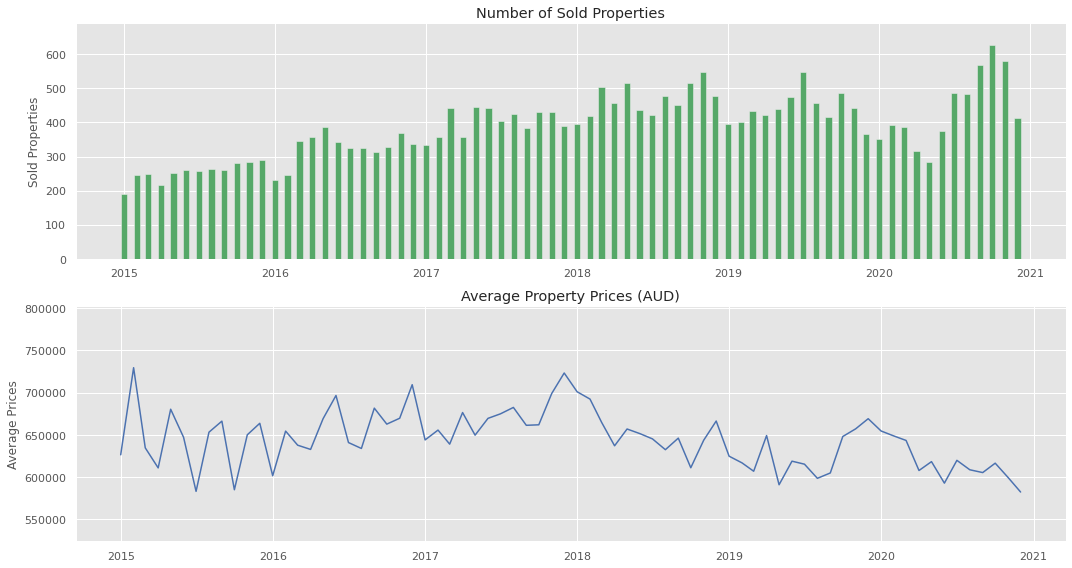

In [178]:
property_market_summary(start_year=2015, end_year=2021)

Suppose I have just won the lottery so I am interested in the houses in City Beach from 2018. Let's check it out.

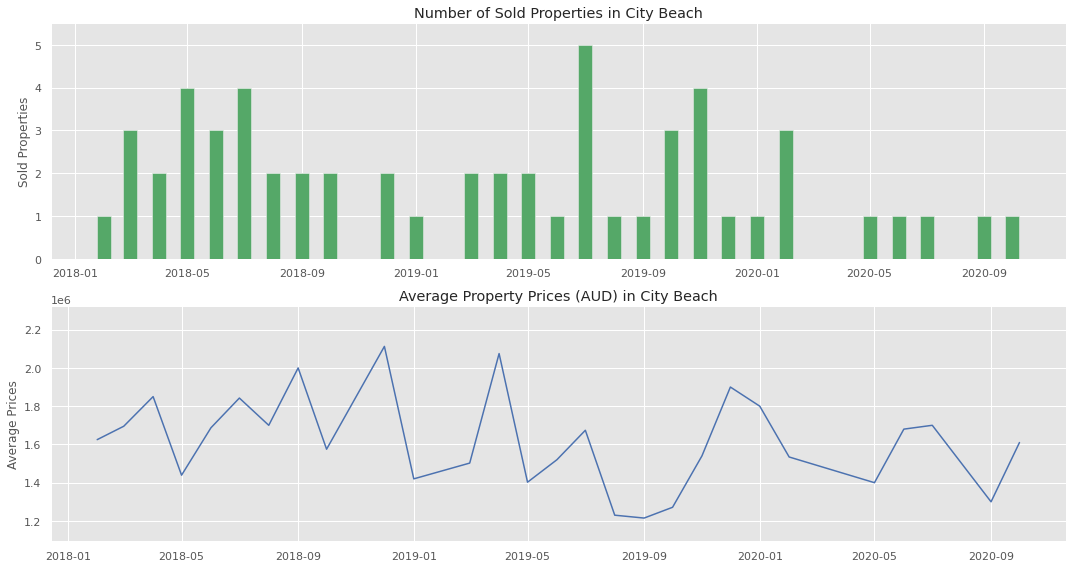

In [179]:
property_market_summary(suburb='City Beach',start_year=2018, end_year=2021)

As we can see, the average house prices in City Beach are much higher when compared to the average prices including all Suburbs. 

I'll keep trying the Lottery!

### West Perth, South Perth, North Perth and, East Perth price comparisson between Jan/2018 and Dec/2020

If you are looking for a house closer to the CBD, this Box Plot may help.

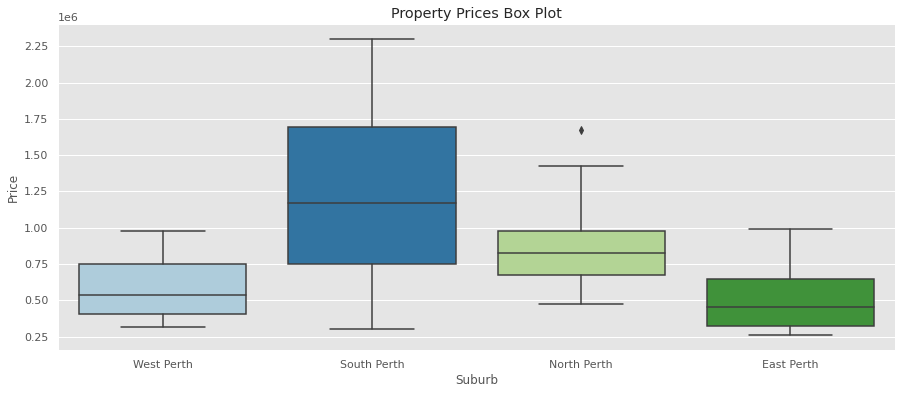

In [258]:
df_p = spark.sql("""
                SELECT
                    Suburb
                    ,Price
                FROM perth_housing
                WHERE suburb LIKE '%Perth%' AND Date_Sold BETWEEN '2018-01-01' AND '2020-12-01'
            """).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax = sns.boxplot(x="Suburb", y="Price", data=df_p, palette="Paired")
    ax.set_title('Property Prices Box Plot')

### 10 first Suburbs in number of sold houses between Jan/2018 and Dec/2020

We can just use SQL to query the data and plot the results

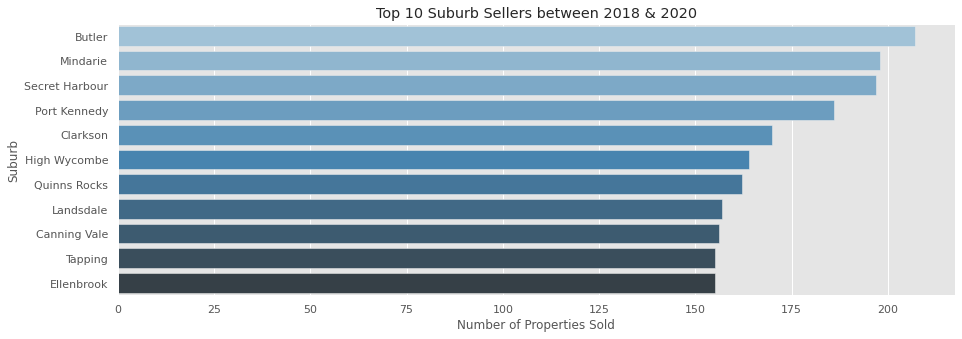

In [255]:
df_sold = spark.sql("""
            SELECT
                Suburb
                ,Number_of_Sold_Houses
            FROM
                (
                SELECT 
                    Suburb
                    ,COUNT(1) as Number_of_Sold_Houses
                    ,RANK() OVER (ORDER BY COUNT(1) DESC) r
                FROM  perth_housing 
                WHERE Date_Sold BETWEEN '2018-01-01' AND '2020-12-01'
                GROUP BY Suburb
                )
            WHERE r <= 10
        """).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.barplot(x="Number_of_Sold_Houses", y='Suburb', data=df_sold, palette="Blues_d")
    ax.set_title('Top 10 Suburb Sellers between 2018 & 2020')
    ax.set_xlabel('Number of Properties Sold')
pass

# Machine Learning - Spark MLlib

Another popular aspect of Spark is its ability to perform large scale machine learning with a built-in library of machine learning algorithms called MLlib. 

MLlib allows for preprocessing, munging, training of models, and making predictions at scale on data.

Spark provides a sophisticated machine learning API for performing a variety of machine learning tasks, from classification to regression, clustering to deep learning. 

To demonstrate this functionality, we will perform some basic regression on our data.

In [62]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

#### Fetch data

In [221]:
data = spark.sql("""
                SELECT 
                    Address, Suburb, Bedrooms, Bathrooms, Garage, Land_Area, Floor_Area, Build_Year, 
                    Cbd_Distance, Nearest_Station, Nearest_Station_Distance
                    ,CAST(DATE_FORMAT(Date_Sold, 'y') AS INT) as Year_Sold
                    ,CAST(DATE_FORMAT(Date_Sold, 'MM') AS INT) as Month_Sold
                    ,Postcode, Latitude,Longitude, Nearest_School, Nearest_School_Distance, Nearest_School_Rank
                    ,Price as label
                FROM perth_housing""")

In [227]:
data.describe()

summary,Address,Suburb,Bedrooms,Bathrooms,Garage,Land_Area,Floor_Area,Build_Year,Cbd_Distance,Nearest_Station,Nearest_Station_Distance,Year_Sold,Month_Sold,Postcode,Latitude,Longitude,Nearest_School,Nearest_School_Distance,Nearest_School_Rank,label
count,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656,33656
mean,null,null,3.659109816971714,1.823062752555265,2.0336344188257667,2622.6048252911814,183.50154504397432,1803.1862372236749,19.77741,null,4.52341,2016.6210185405278,6.764588780603756,6089.420073686712,-31.96066391017865,115.8792646544981,null,1.81499,49.02418588067506,637072.0057939149
stddev,null,null,0.7520381246740109,0.587426789477283,1.307281935796926,12704.952619275484,72.10298226215527,580.2921250274674,11.364368177047881,null,4.495047274129324,3.5054771393179687,3.3881992457524888,62.16792117612666,0.17777952121362295,0.11813660885272191,null,1.7460963920298411,47.68132973761617,355825.63273659314
min,1 Acorn Place,Alexander Heights,1,1,0,61,1,0,0.7,Armadale Station,0.0,1988,1,6003,-32.47297865,115.58273,Alkimos Baptist C...,0.1,0,51000
max,9E Margaret Street,Yokine,10,16,32,566786,870,2017,59.8,Woodbridge Station,35.5,2020,12,6558,-31.45745,116.343201,Youth Futures Com...,23.3,139,2440000


#### String Indexer

In [64]:
from pyspark.ml.feature import StringIndexer

categorical_columns_in = ['Address', 'Suburb', 'Nearest_Station', 'Postcode', 'Nearest_School']
categorical_columns_out = [column + "Index" for column in categorical_columns_in]

indexer = StringIndexer(inputCols=categorical_columns_in, 
                        outputCols=categorical_columns_out)

indexed = indexer.fit(data).transform(data)

#### One Hot Encoder

In [65]:
from pyspark.ml.feature import OneHotEncoder

encoder_columns_in = categorical_columns_out
encoder_columns_out = [column.replace('Index', 'Vec') for column in encoder_columns_in]

encoder = OneHotEncoder(inputCols=encoder_columns_in,
                        outputCols=encoder_columns_out)

model = encoder.fit(indexed)
encoded = model.transform(indexed)

#### Cast data types

In [66]:
from pyspark.sql.types import DoubleType

continuous_columns=['Land_Area', 'Floor_Area', 'Cbd_Distance', 'Nearest_Station_Distance',
                    'Latitude', 'Longitude', 'Nearest_School_Distance']

for column in continuous_columns:
    
    encoded = encoded.withColumn(column, encoded[column].cast(DoubleType()))

#### Vector Assembler

In [67]:
###
from pyspark.ml.feature import VectorAssembler

features_list = ['AddressVec', 'SuburbVec', 'Bedrooms', 'Bathrooms', 'Garage', 'Land_Area', 'Floor_Area', 
                 'Build_Year', 'Cbd_Distance', 'Nearest_StationVec', 'Nearest_Station_Distance', 'Year_Sold', 
                 'Month_Sold', 'PostcodeVec', 'Latitude', 'Longitude', 'Nearest_SchoolVec', 
                 'Nearest_School_Distance', 'Nearest_School_Rank']


vectorAssembler = VectorAssembler(inputCols=features_list,
                                  outputCol="features")
                                  
features_vectorized = vectorAssembler.transform(encoded)

#### Normalizer

In [68]:
from pyspark.ml.feature import Normalizer

normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

l1NormData = normalizer.transform(features_vectorized)

In [69]:
df_ml = l1NormData.select('label', 'features_norm')
df_ml.show(5)

+------+--------------------+
| label|       features_norm|
+------+--------------------+
|565000|(34238,[89,33613,...|
|365000|(34238,[90,33753,...|
|287000|(34238,[91,33663,...|
|255000|(34238,[92,33713,...|
|325000|(34238,[93,33614,...|
+------+--------------------+
only showing top 5 rows



#### Split data into trainingData and testData

In [70]:
(trainingData, testData) = df_ml.randomSplit([0.8, 0.2])

### Random Forest Regression

In [74]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline


rf = RandomForestRegressor(featuresCol='features_norm', labelCol='label')

pipeline = Pipeline(stages=[rf])

rf_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

paramGrid = (ParamGridBuilder() 
                .addGrid(rf.maxDepth, [2, 5, 10]) 
                .addGrid(rf.maxBins, [5, 10, 20]) 
                .addGrid(rf.numTrees, [2, 5, 10]) 
                .build())

cvmodel = CrossValidator(estimator = pipeline,
                        estimatorParamMaps = paramGrid,
                        evaluator = rf_evaluator,
                        numFolds = 5)

rf_model = cvmodel.fit(trainingData)

rf_predictions = rf_model.transform(testData)

display(rf_predictions.select("prediction", "label", "features_norm").limit(5))


rf_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
rf_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = rf_evaluator.evaluate(rf_predictions)
rf_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = rf_evaluator.evaluate(rf_predictions)

print(f'Root Mean Squared Error (RMSE) on test data = {rmse}')
print(f'R Square (r2) on test data = {r2}')
print(f'Mean Absolute Error (MAE) on test data = {mae}')

### Linear Regression

In [72]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

lr = LinearRegression(featuresCol = 'features_norm', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)

pipeline = Pipeline(stages=[lr])

lr_model = pipeline.fit(trainingData)

lr_predictions = lr_model.transform(testData)

display(lr_predictions.select("prediction", "label").limit(5))

from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(lr_predictions)
lr_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = lr_evaluator.evaluate(lr_predictions)
lr_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = lr_evaluator.evaluate(lr_predictions)

print(f'Root Mean Squared Error (RMSE) on test data = {rmse}')
print(f'R Square (r2) on test data = {r2}')
print(f'Mean Absolute Error (MAE) on test data = {mae}')

prediction,label
702779.7367630956,52000
353978.3918355361,60000
558756.6402082352,65000
402620.41852351674,66000
545717.9512600253,75000


Root Mean Squared Error (RMSE) on test data = 205047.19612306842
R Square (r2) on test data = 0.6701650817043956
Mean Absolute Error (MAE) on test data = 130215.96474851678


### Gradient-boosted Tree Regression

In [73]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

gbt = GBTRegressor(featuresCol = 'features_norm', labelCol = 'label', maxIter=10)

pipeline = Pipeline(stages=[gbt])

gbt_model = pipeline.fit(trainingData)

gbt_predictions = gbt_model.transform(testData)

display(gbt_predictions.select('prediction', 'label').limit(5))

from pyspark.ml.evaluation import RegressionEvaluator

gbt_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
gbt_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)
gbt_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = gbt_evaluator.evaluate(gbt_predictions)

print(f'Root Mean Squared Error (RMSE) on test data = {rmse}')
print(f'R Square (r2) on test data = {r2}')
print(f'Mean Absolute Error (MAE) on test data = {mae}')

prediction,label
804343.6835146605,52000
336712.1271661885,60000
613538.628510887,65000
325859.9416256783,66000
538745.278262857,75000


Root Mean Squared Error (RMSE) on test data = 217042.06628333832
R Square (r2) on test data = 0.6304469495741027
Mean Absolute Error (MAE) on test data = 148134.85839007975
